In [189]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import pandas as pd

In [190]:
# Define transformations to apply to the data
transform = transforms.ToTensor()

# Load the CIFAR dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [191]:
torch.manual_seed(4)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [192]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [193]:
class CifarModel(nn.Module):
  def __init__(self, input, hidden_layer1, hidden_layer2, output):
        super(CifarModel, self).__init__()
        self.fc1 = nn.Linear(input, hidden_layer1)
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.out = nn.Linear(hidden_layer2, output)

  def forward(self, x):
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = torch.relu(self.out(x))
      return x

In [194]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from IPython.display import display

cifarModel = CifarModel(3072, 512, 256, 10).to(torch.device('cuda'))

criterion = FocalLoss()
optimizer = torch.optim.SGD(cifarModel.parameters(), lr=0.01, momentum=0.9)

losses = []
accuracies = []
precisions_micro = []
recalls_micro = []
f1_scores_micro = []
precisions_macro = []
recalls_macro = []
f1_scores_macro = []
precisions_weighted = []
recalls_weighted = []
f1_scores_weighted = []

epoch = 100

for i in range(epoch):
  curr_loss = 0.0
  y_true = []
  y_pred = []

  for j, data in enumerate(train_loader):
    input, output = data[0].to(torch.device('cuda')), data[1].to(torch.device('cuda'))
    input = input.reshape(50, -1)

    optimizer.zero_grad()

    pred_out = cifarModel.forward(input)
    loss = criterion(pred_out, output)

    loss.backward()
    optimizer.step()

    curr_loss += loss.item()
    y_true += output.tolist()
    y_pred += torch.argmax(pred_out, dim=1).tolist()

  loss_avg = curr_loss / len(train_loader)
  losses.append(loss_avg)

  acc = accuracy_score(y_true, y_pred)
  accuracies.append(acc*100)

  precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=1)
  precisions_micro.append(precision_micro)
  recalls_micro.append(recall_micro)
  f1_scores_micro.append(f1_micro)

  precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)
  precisions_macro.append(precision_macro)
  recalls_macro.append(recall_macro)
  f1_scores_macro.append(f1_macro)

  precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=1)
  precisions_weighted.append(precision_weighted)
  recalls_weighted.append(recall_weighted)
  f1_scores_weighted.append(f1_weighted)
  print(f'epoch: {i:2}  loss: {loss_avg}')



perf_metrics = {
    'loss': losses,
    'accuracy': accuracies,
    'precision_micro': precisions_micro,
    'recall_micro': recalls_micro,
    'f1_micro': f1_scores_micro,
    'precision_macro': precisions_macro,
    'recall_macro': recalls_macro,
    'f1_macro': f1_scores_macro,
    'precision_weighted': precisions_weighted,
    'recall_weighted': recalls_weighted,
    'f1_weighted': f1_scores_weighted
}

perf_metrics_df = pd.DataFrame(perf_metrics)
display(perf_metrics_df)



epoch:  0  loss: 1.4658070210814476
epoch:  1  loss: 1.2044433211088181
epoch:  2  loss: 1.1192858953475953
epoch:  3  loss: 1.059104755461216
epoch:  4  loss: 1.0125483709573746
epoch:  5  loss: 0.9847948623895645
epoch:  6  loss: 0.950278680562973
epoch:  7  loss: 0.9261342034339904
epoch:  8  loss: 0.8965807240605355
epoch:  9  loss: 0.8719925097823144
epoch: 10  loss: 0.8500361394286156
epoch: 11  loss: 0.8260210618078708
epoch: 12  loss: 0.804844992518425
epoch: 13  loss: 0.7832600736320019
epoch: 14  loss: 0.7638385422825813
epoch: 15  loss: 0.7484611283242703
epoch: 16  loss: 0.7400434395670891
epoch: 17  loss: 0.7176164557337761
epoch: 18  loss: 0.7016793635487556
epoch: 19  loss: 0.6819396876096725
epoch: 20  loss: 0.6660139093101025
epoch: 21  loss: 0.6584163549244404
epoch: 22  loss: 0.6467202595174313
epoch: 23  loss: 0.6281032477617263
epoch: 24  loss: 0.617585739850998
epoch: 25  loss: 0.5998836268484592
epoch: 26  loss: 0.5869440545886755
epoch: 27  loss: 0.5723935806006

,loss,accuracy,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
0,1.465807,30.262,0.30262,0.30262,0.30262,0.293990,0.30262,0.288843,0.293990,0.30262,0.288843
1,1.204443,38.716,0.38716,0.38716,0.38716,0.382417,0.38716,0.382774,0.382417,0.38716,0.382774
2,1.119286,41.918,0.41918,0.41918,0.41918,0.414815,0.41918,0.415095,0.414815,0.41918,0.415095
3,1.059105,44.024,0.44024,0.44024,0.44024,0.435844,0.44024,0.436110,0.435844,0.44024,0.436110
4,1.012548,45.966,0.45966,0.45966,0.45966,0.455903,0.45966,0.456142,0.455903,0.45966,0.456142
...,...,...,...,...,...,...,...,...,...,...,...
95,0.155955,87.300,0.87300,0.87300,0.87300,0.873070,0.87300,0.873025,0.873070,0.87300,0.873025
96,0.151276,87.492,0.87492,0.87492,0.87492,0.874980,0.87492,0.874943,0.874980,0.87492,0.874943
97,0.157293,87.244,0.87244,0.87244,0.87244,0.872455,0.87244,0.872436,0.872455,0.87244,0.872436
98,0.149883,87.566,0.87566,0.87566,0.87566,0.875685,0.87566,0.875662,0.875685,0.87566,0.875662


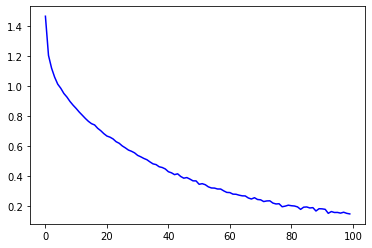

In [195]:
plt.plot(range(epoch), losses, 'b')

In [196]:
correct = 0
total = 0

target_out = []
pred_out = []
with torch.no_grad():
    for (i, data) in enumerate(test_loader):
        images, labels = data[0].to(torch.device('cuda')), data[1].to(torch.device('cuda'))
        # Predict the class of the image
        images = images.reshape(100, -1)
        outputs = cifarModel.forward(images)
        _, predicted = torch.max(outputs.data, 1)

        pred_out += predicted.tolist()
        target_out += labels.tolist()


loss_avg = curr_loss / len(train_loader)

acc = accuracy_score(y_true, y_pred)

precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')


precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')


precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')


perf_metrics = {
    'loss': [loss_avg],
    'accuracy': [acc*100],
    'precision_micro': [precision_micro*100],
    'recall_micro': [recall_micro*100],
    'f1_micro': [f1_micro*100],
    'precision_macro': [precision_macro*100],
    'recall_macro': [recall_macro*100],
    'f1_macro': [f1_macro*100],
    'precision_weighted': [precision_weighted*100],
    'recall_weighted': [recall_weighted*100],
    'f1_weighted': [f1_weighted*100]
}

perf_metrics_df = pd.DataFrame(perf_metrics)
display(perf_metrics_df)


,loss,accuracy,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
0,0.145977,87.928,87.928,87.928,87.928,87.933807,87.928,87.929839,87.933807,87.928,87.929839
